## Load libraries

In [1]:
# !pip install catboost
import sqlite3
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
# create connection
# cnx = sqlite3.connect(r"C:\Users\PC\Downloads\kabam_ds_interview\kabam_ds_interview\ka_devices.db")
# path_ka_actions = r"C:\Users\PC\Downloads\kabam_ds_interview\kabam_ds_interview\ka_actions.parquet"
# path_ka_users = r"C:\Users\PC\Downloads\kabam_ds_interview\kabam_ds_interview\ka_users.csv"


cnx = sqlite3.connect(r"C:\Users\thinhdp1\OneMountGroup\Take_home_exame\kabam_ds_interview\kabam_ds_interview\ka_devices.db")
path_ka_actions = r"C:\Users\thinhdp1\OneMountGroup\Take_home_exame\kabam_ds_interview\kabam_ds_interview\ka_actions.parquet"
path_ka_users = r"C:\Users\thinhdp1\OneMountGroup\Take_home_exame\kabam_ds_interview\kabam_ds_interview\ka_users.csv"

def load_data():
    global cnx
    global path_ka_actions
    global path_ka_users
    
    query = f"""
    SELECT * FROM devices
    """
    
    df_devices = pd.read_sql_query(query,cnx)
    df_actions = pd.read_parquet(path_ka_actions)
    df_users = pd.read_csv(path_ka_users)
    
    return df_devices, df_actions, df_users

## User defined Function

In [5]:
def impute_data(df_input,num_cols,cate_cols):
    df_output = df_input.copy()
    num_rows = df_output.shape[0]
    
    # to impute data, if col is numerical - impute by median value, if col is categorical - impute by mode value
    for col in num_cols:
        if df_output[col].nunique() < num_rows:
            median_value = df_output[col].median()
            df_output[col].fillna(median_value, inplace = True)
        else:
            pass
        
    for col in cate_cols:
        if df_output[col].nunique() < num_rows:
            mode_value = df_output[col].mode()
            df_output[col].fillna(mode_value, inplace = True)
        else:
            pass
        
    return df_output

In [6]:
def build_feature(df_input,col_name):
    df_tmp_01 = df_input.groupby(col_name)['uid_s'].count().reset_index(name = 'num_users')
    df_tmp_02 = df_input.groupby(col_name)['total_spend'].sum().reset_index(name = 'total_spend')
    df_tmp_03 = pd.merge(df_tmp_01,df_tmp_02, on = col_name)
    df_tmp_03['spend_per_user'] = df_tmp_03['total_spend']/df_tmp_03['num_users']
    
    df_active = df_input.loc[df_input.total_spend > 0]
    df_tmp_04 = df_active.groupby(col_name)['uid_s'].count().reset_index(name = 'num_active_users')
    df_tmp_05 = df_active.groupby(col_name)['total_spend'].sum().reset_index(name = 'total_spend')
    df_tmp_06 = pd.merge(df_tmp_04,df_tmp_05, on = col_name)
    df_tmp_06['spend_per_active_user'] = df_tmp_06['total_spend'] / df_tmp_06['num_active_users']
    
    df_final = pd.merge(df_tmp_03,df_tmp_06[[col_name,'num_active_users','spend_per_active_user']], on = col_name, how = 'outer')
    
    df_final['ratio_active_users'] = df_final['num_active_users'] / df_final['num_users']
    df_final.fillna(0, inplace = True)
    
    return df_final

In [7]:
def cluster_by_KMeans(df_input,params_dict):
    # get the following parameters
    # primary_key, num_clusters, li_feats, need_scaling, li_cluster_names
    primary_key = params_dict['primary_key']
    num_clusters = params_dict['num_clusters']
    li_feats = params_dict['li_feats']
    need_scaling = params_dict['need_scaling']
    
    if 'li_cluster_names' in params_dict:
        li_cluster_names = params_dict['li_cluster_names']
    else:
        li_cluster_names = li_feats.copy()
    
    df_feats = df_input[li_feats]
    if need_scaling == 'Y':
        scaler = StandardScaler()
        scaler.fit(df_feats)
        
        X_scale = scaler.transform(df_feats)
        df_feats_scale = pd.DataFrame(X_scale, columns = df_feats.columns)
    else:
        df_feats_scale = df_feats.copy()
        
    km = KMeans(n_clusters = num_clusters, init = 'k-means++', random_state = 2021)
    km.fit(df_feats_scale)
    df_tmp = pd.DataFrame(km.labels_, columns = ['label'])
    
    df_output = pd.concat([df_input,df_tmp], axis = 1)
    
    df_output = df_output[[primary_key,'label']]
    
    # relabel cluster
    df_tmp = df_output.copy()
    
    df_tmp_01 = df_tmp.groupby('label')[primary_key].count().reset_index(name = 'num_elements')
    
    df_tmp_02 = df_tmp_01.sort_values(by = 'num_elements', ascending = False).reset_index(drop = True)
    df_tmp_02['new_label'] = df_tmp_02.index
    df_output_01 = pd.merge(df_output,df_tmp_02, on = 'label', how = 'left')
    
    df_output_02 = df_output_01[[primary_key,'new_label']]
    df_output_02.rename(columns = {'new_label': 'label'}, inplace = True)
    
    df_output_03 = pd.merge(df_output_02,df_input[[primary_key] + li_feats], on = primary_key)
    
    return df_output_03

In [8]:
def build_mapping(df_input,col_name):
    df_tmp = build_feature(df_input,col_name)
    
    my_list = ['num_users','total_spend','spend_per_user','num_active_users','spend_per_active_user','ratio_active_users']

    params_dict = {
        'primary_key': col_name,
        'num_clusters': 30,
        'li_feats': my_list,
        'need_scaling': 'Y'
    }
    
    df_clustered = cluster_by_KMeans(df_tmp,params_dict)
    
    selected_cols = [col_name,'label']
    df_clustered = df_clustered[selected_cols]
    df_clustered.rename(columns = {'label': 'label_' + col_name}, inplace = True)
    
    return df_clustered

In [9]:
def analyze_cate_col(df_input,col_name):
    df_tmp_01 = df_input.groupby(col_name)['uid_s'].count().reset_index(name = 'num_users')
    df_tmp_02 = df_input.groupby(col_name)['total_spend'].sum().reset_index(name = 'total_spend')
    df_tmp_03 = pd.merge(df_tmp_01,df_tmp_02, on = col_name)
    df_tmp_03['spend_per_user'] = df_tmp_03['total_spend']/df_tmp_03['num_users']
    
    df_active = df_input.loc[df_input.total_spend > 0]
    df_tmp_04 = df_active.groupby(col_name)['uid_s'].count().reset_index(name = 'num_active_users')
    df_tmp_05 = df_active.groupby(col_name)['total_spend'].sum().reset_index(name = 'total_spend')
    df_tmp_06 = pd.merge(df_tmp_04,df_tmp_05, on = col_name)
    df_tmp_06['spend_per_active_user'] = df_tmp_06['total_spend'] / df_tmp_06['num_active_users']
    
    df_final = pd.merge(df_tmp_03,df_tmp_06[[col_name,'num_active_users','spend_per_active_user']], on = col_name, how = 'outer')
    
    df_final['ratio_active_users'] = df_final['num_active_users'] / df_final['num_users']
    df_final.fillna(0, inplace = True)
    
    return df_final

def encode_categorical_col(df_input_01,df_input_02,col_name):
    selected_cols = [col_name,'ratio_active_users']
    df_tmp_01 = df_input_02[selected_cols]
    
    df_output = pd.merge(df_input_01,df_tmp_01, on = col_name)
    df_output.drop(columns = [col_name], inplace = True)
    df_output.rename(columns = {'ratio_active_users': col_name}, inplace = True)
    
    return df_output

## Main Program

In [10]:
#### Load data ####
df_devices, df_actions, df_users = load_data()

In [11]:
# combine df_devices, df_actions, df_users into dataframe
df_full = pd.merge(df_actions, df_devices, on = 'uid_s', how = 'outer')
df_full = pd.merge(df_full, df_users, on = 'uid_s', how = 'outer')

# drop the redundant column 'index'
df_full.drop(columns = 'index', inplace = True)

In [12]:
# take a look at data and pick 'numerical' type columns and 'categorical' type columns
numerical_cols = ['logins','game_stats_tutorial_complete_time','game_stats_xp','game_stats_xp1',
                 'game_stats_xp2','game_stats_xp3','redeemer_actions','scribe_actions',
                 'device_height_i','total_spend']

categorical_cols = ['game_stats_tutorial_complete','platform_s','device_mapped_s',
                   'device_manufacturer_s','device_mem_i','device_gmem_i',
                   'device_mem_grouping_i','device_gmem_grouping_i','device_numcpu_i',
                   'device_gpu_s','device_os_s','device_model_s','lang_s','geo_s',
                   'region_s','tz_i','local_time_join_hour','local_time_join_dow']

In [13]:
# convert to string type for categorical cols
for col in categorical_cols:
    df_full[col] = df_full[col].astype('str')

In [14]:
# For our analysis, we filter the uid_s that completed tutorial only
df_valid = df_full.loc[df_full.game_stats_tutorial_complete == '1.0']

In [15]:
# We now can safely remove the column 'game_stats_tutorial_complete'
df_valid.drop(columns = ['game_stats_tutorial_complete'], inplace = True)

# Remove the element 'game_stats_tutorial_complete' out of categorical cols
found_idx = categorical_cols.index('game_stats_tutorial_complete')
del categorical_cols[found_idx]

In [16]:
# take a look at null_counts for each columns
df_valid.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751748 entries, 0 to 2845930
Data columns (total 28 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   uid_s                              1751748 non-null  int64  
 1   logins                             1751736 non-null  float64
 2   game_stats_tutorial_complete_time  1751748 non-null  float64
 3   game_stats_xp                      1751685 non-null  float64
 4   game_stats_xp1                     1751685 non-null  float64
 5   game_stats_xp2                     1751685 non-null  float64
 6   game_stats_xp3                     1751685 non-null  float64
 7   redeemer_actions                   1751748 non-null  float64
 8   scribe_actions                     1751748 non-null  float64
 9   platform_s                         1751748 non-null  object 
 10  device_mapped_s                    1751748 non-null  object 
 11  device_manufacturer_s   

In [17]:
# perform imputation to ensure no null rows
df_valid_01 = impute_data(df_valid,numerical_cols,categorical_cols)

In [18]:
# Take a look again to ensure no null rows
df_valid_01.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751748 entries, 0 to 2845930
Data columns (total 28 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   uid_s                              1751748 non-null  int64  
 1   logins                             1751748 non-null  float64
 2   game_stats_tutorial_complete_time  1751748 non-null  float64
 3   game_stats_xp                      1751748 non-null  float64
 4   game_stats_xp1                     1751748 non-null  float64
 5   game_stats_xp2                     1751748 non-null  float64
 6   game_stats_xp3                     1751748 non-null  float64
 7   redeemer_actions                   1751748 non-null  float64
 8   scribe_actions                     1751748 non-null  float64
 9   platform_s                         1751748 non-null  object 
 10  device_mapped_s                    1751748 non-null  object 
 11  device_manufacturer_s   

### Handle Categorical Variables

In [19]:
# The dataset has many categorical columns that need to be encoded such that we can do further analysis
categorical_cols

['platform_s',
 'device_mapped_s',
 'device_manufacturer_s',
 'device_mem_i',
 'device_gmem_i',
 'device_mem_grouping_i',
 'device_gmem_grouping_i',
 'device_numcpu_i',
 'device_gpu_s',
 'device_os_s',
 'device_model_s',
 'lang_s',
 'geo_s',
 'region_s',
 'tz_i',
 'local_time_join_hour',
 'local_time_join_dow']

In [20]:
# we split list of categorical cols into two parts
# li_01 includes cols that have number of distinct values less than or equal to 30
# li_02 includes cols that have number of distinct values > 30

li_01 = []
li_02 = []

for col in categorical_cols:
    num_distinct_values = df_valid_01[col].nunique()
    if num_distinct_values <= 30:
        li_01.append(col)
    else:
        li_02.append(col)

In [21]:
li_01

['platform_s',
 'device_gmem_i',
 'device_gmem_grouping_i',
 'device_numcpu_i',
 'lang_s',
 'region_s',
 'local_time_join_hour',
 'local_time_join_dow']

In [22]:
li_02

['device_mapped_s',
 'device_manufacturer_s',
 'device_mem_i',
 'device_mem_grouping_i',
 'device_gpu_s',
 'device_os_s',
 'device_model_s',
 'geo_s',
 'tz_i']

In [23]:
# for each col in li_02, we reduce the number of distinct values down to 30 values through clustering technique
df_valid_02 = df_valid_01.copy()

for col_name in li_02:
    # reduce number of distinct values to 30  ones through clustering
    df_clustered = build_mapping(df_valid_02,col_name)
    
    # remapping to the original data
    df_valid_02 = pd.merge(df_valid_02,df_clustered, on = col_name)

In [24]:
df_valid_03 = df_valid_02.drop(columns = li_02)

my_dict = {}
for col in li_02:
    my_dict['label_' + col] = col
    
df_valid_03.rename(columns = my_dict, inplace = True)

for col in li_02:
    df_valid_03[col] = df_valid_03[col].astype('str')

In [25]:
df_valid_03.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751748 entries, 0 to 1751747
Data columns (total 28 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   uid_s                              1751748 non-null  int64  
 1   logins                             1751748 non-null  float64
 2   game_stats_tutorial_complete_time  1751748 non-null  float64
 3   game_stats_xp                      1751748 non-null  float64
 4   game_stats_xp1                     1751748 non-null  float64
 5   game_stats_xp2                     1751748 non-null  float64
 6   game_stats_xp3                     1751748 non-null  float64
 7   redeemer_actions                   1751748 non-null  float64
 8   scribe_actions                     1751748 non-null  float64
 9   platform_s                         1751748 non-null  object 
 10  device_gmem_i                      1751748 non-null  object 
 11  device_gmem_grouping_i  

In [26]:
# encoding the categorical col value by its ratio of num users spending moeny over num users within that category
df_valid_04 = df_valid_03.copy()

for col in categorical_cols:
    df_tmp = analyze_cate_col(df_valid_04,col)
    df_valid_04 = encode_categorical_col(df_valid_04,df_tmp,col)

In [27]:
df_valid_04.shape

(1751748, 28)

### Formulate ML problem

In [28]:
# create binary class
df_no_spend = df_valid_04.loc[df_valid_04.total_spend == 0] # filter the users that didn't spend moeny
df_spend = df_valid_04.loc[df_valid_04.total_spend > 0] # filter the users that have paid money

df_no_spend['class'] = 0
df_spend['class'] = 1

df_final = pd.concat([df_no_spend,df_spend])

# drop columns 'total_spend'
df_final.drop(columns = ['total_spend'], inplace = True)

In [29]:
df_final.head()

,uid_s,logins,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_height_i,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_gpu_s,device_os_s,device_model_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,class
0,0,7.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0,720.0,0.014012,0.012621,0.007881,0.000433,0.019154,0.017829,0.019154,0.017960,0.011645,0.000475,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104,0
1,1263488,2.0,5.390000e+08,317.0,317.0,0.0,0.0,88.0,133.0,720.0,0.014012,0.012621,0.010965,0.005308,0.013537,0.005112,0.013537,0.017960,0.011645,0.000475,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104,0
2,2604392,2.0,1.382000e+09,80.0,80.0,0.0,0.0,43.0,116.0,720.0,0.014012,0.013300,0.017561,0.008690,0.039324,0.035357,0.039324,0.017960,0.017652,0.000475,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104,0
3,1263264,3.0,5.440000e+08,80.0,80.0,0.0,0.0,42.0,124.0,720.0,0.014012,0.012621,0.013295,0.008153,0.013537,0.005112,0.013537,0.004528,0.004829,0.016308,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104,0
4,2604519,3.0,7.100000e+08,317.0,317.0,0.0,0.0,87.0,146.0,720.0,0.014012,0.012621,0.013295,0.008153,0.013537,0.005112,0.013537,0.004528,0.004829,0.016308,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104,0


In [30]:
df_final.groupby('class')['uid_s'].count().reset_index(name = 'num_users')

,class,num_users
0,0,1721056
1,1,30692


In [31]:
# We see strongly imbalance data. We now sampling data to ensure the more balance ratio of two class

In [32]:
# Our purpose to figure out which users are highly likely to spend money after finishing tutorial.
# Our approach: Based on the class 1 - the set of users have spend money we try to figure out the 'region' of these users
# How? By formulate the binary classification problem, we can identify two regions for user spending money and user that don't spend money.
# In the above we have ~ 30K users that spend money but ~1.7 million of users don't spend money.
# For easier to create the boundary, we sampling around 30K users among 1.7 million of users don't spend money for training a binary classification problem

df_final_01 = df_final.copy()

df_class_0 = df_final_01.loc[df_final_01['class'] == 0]
df_class_1 = df_final_01.loc[df_final_01['class'] == 1]

num_samples = len(df_class_1)

# sampling
df_subset_0 = df_class_0.sample(n = num_samples, random_state = 2021)

data = pd.concat([df_subset_0,df_class_1])

In [33]:
data.head()

,uid_s,logins,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_height_i,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_gpu_s,device_os_s,device_model_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,class
698260,673187,2.0,465000000.0,887.0,887.0,0.0,0.0,198.0,205.0,750.0,0.028333,0.013642,0.028331,0.012282,0.005132,0.007271,0.005132,0.019584,0.017652,0.026012,0.013643,0.017351,0.010604,0.015954,0.015199,0.015489,0.016981,0
916503,263703,2.0,470000000.0,92.0,92.0,0.0,0.0,53.0,124.0,480.0,0.014012,0.013300,0.021448,0.008153,0.005132,0.007271,0.005132,0.000360,0.000149,0.016882,0.013138,0.021311,0.020858,0.017268,0.020272,0.028539,0.016981,0
1417458,174374,2.0,745000000.0,310.0,310.0,0.0,0.0,113.0,146.0,720.0,0.014012,0.012383,0.013295,0.008153,0.019154,0.015815,0.019154,0.017960,0.018821,0.016882,0.006165,0.021311,0.020858,0.017268,0.020272,0.015489,0.018575,0
236010,1141120,2.0,615000000.0,6539.0,1766.0,3001.0,1772.0,979.0,368.0,1080.0,0.014012,0.012519,0.021448,0.023035,0.019154,0.015815,0.019154,0.017960,0.011645,0.016116,0.010929,0.021311,0.020858,0.017268,0.020272,0.015489,0.019463,0
930000,319924,7.0,494000000.0,16183.0,2104.0,2714.0,50.0,1648.0,502.0,1536.0,0.028333,0.012383,0.028331,0.008153,0.005132,0.007271,0.005132,0.019584,0.004829,0.016882,0.013793,0.021311,0.020858,0.017268,0.020272,0.017512,0.016981,0


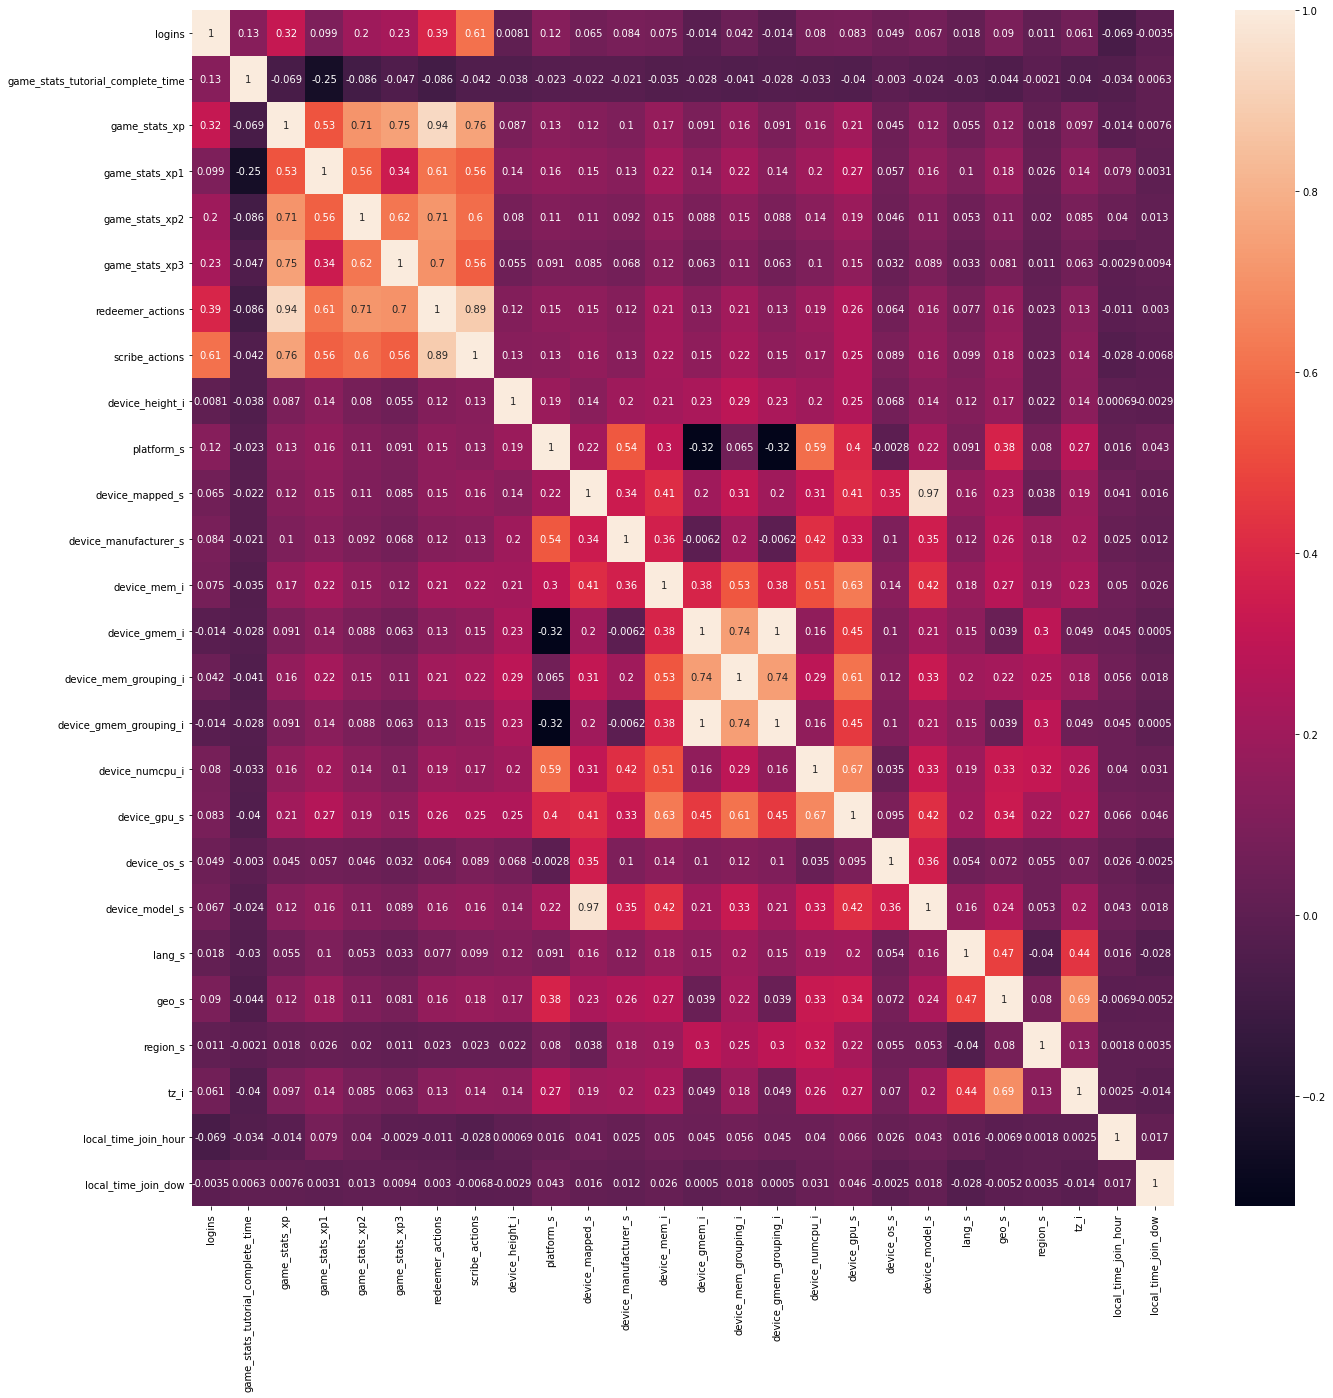

In [34]:
# take a look at correlation heatmap
df_num = data.drop(columns = ['uid_s','class'])
corrMatrix = df_num.corr()
fig, ax = plt.subplots(figsize=(22,22))
sns.heatmap(corrMatrix, annot = True, ax = ax)
plt.show()

In [35]:
# drop one among pair of two strongly correlated features (device_model_s, device_mapped_s), (redeemer_actions,game_stats_xp)
dropped_cols = ['device_mapped_s','game_stats_xp']

data.drop(columns = dropped_cols, inplace = True)

In [36]:
data.reset_index(drop = True, inplace = True)

In [37]:
data.shape

(61384, 26)

In [38]:
data.head()

,uid_s,logins,game_stats_tutorial_complete_time,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_height_i,platform_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_gpu_s,device_os_s,device_model_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,class
0,673187,2.0,465000000.0,887.0,0.0,0.0,198.0,205.0,750.0,0.028333,0.028331,0.012282,0.005132,0.007271,0.005132,0.019584,0.017652,0.026012,0.013643,0.017351,0.010604,0.015954,0.015199,0.015489,0.016981,0
1,263703,2.0,470000000.0,92.0,0.0,0.0,53.0,124.0,480.0,0.014012,0.021448,0.008153,0.005132,0.007271,0.005132,0.000360,0.000149,0.016882,0.013138,0.021311,0.020858,0.017268,0.020272,0.028539,0.016981,0
2,174374,2.0,745000000.0,310.0,0.0,0.0,113.0,146.0,720.0,0.014012,0.013295,0.008153,0.019154,0.015815,0.019154,0.017960,0.018821,0.016882,0.006165,0.021311,0.020858,0.017268,0.020272,0.015489,0.018575,0
3,1141120,2.0,615000000.0,1766.0,3001.0,1772.0,979.0,368.0,1080.0,0.014012,0.021448,0.023035,0.019154,0.015815,0.019154,0.017960,0.011645,0.016116,0.010929,0.021311,0.020858,0.017268,0.020272,0.015489,0.019463,0
4,319924,7.0,494000000.0,2104.0,2714.0,50.0,1648.0,502.0,1536.0,0.028333,0.028331,0.008153,0.005132,0.007271,0.005132,0.019584,0.004829,0.016882,0.013793,0.021311,0.020858,0.017268,0.020272,0.017512,0.016981,0


In [39]:
# Take users in df_final but not in data
df_tmp = data[['uid_s']]
df_tmp['flag'] = 1

df_tmp_01 = pd.merge(df_final,df_tmp, on = 'uid_s', how = 'left')
df_tmp_02 = df_tmp_01.loc[df_tmp_01.flag.isna()]
df_tmp_02.drop(columns = ['flag','class'], inplace = True)

data_not_for_train = df_tmp_02.copy()

In [40]:
data_not_for_train.head()

,uid_s,logins,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_height_i,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_gpu_s,device_os_s,device_model_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow
0,0,7.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0,720.0,0.014012,0.012621,0.007881,0.000433,0.019154,0.017829,0.019154,0.017960,0.011645,0.000475,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104
1,1263488,2.0,5.390000e+08,317.0,317.0,0.0,0.0,88.0,133.0,720.0,0.014012,0.012621,0.010965,0.005308,0.013537,0.005112,0.013537,0.017960,0.011645,0.000475,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104
2,2604392,2.0,1.382000e+09,80.0,80.0,0.0,0.0,43.0,116.0,720.0,0.014012,0.013300,0.017561,0.008690,0.039324,0.035357,0.039324,0.017960,0.017652,0.000475,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104
3,1263264,3.0,5.440000e+08,80.0,80.0,0.0,0.0,42.0,124.0,720.0,0.014012,0.012621,0.013295,0.008153,0.013537,0.005112,0.013537,0.004528,0.004829,0.016308,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104
4,2604519,3.0,7.100000e+08,317.0,317.0,0.0,0.0,87.0,146.0,720.0,0.014012,0.012621,0.013295,0.008153,0.013537,0.005112,0.013537,0.004528,0.004829,0.016308,0.011801,0.017437,0.013905,0.017268,0.020272,0.015585,0.018104


In [41]:
# Now we have dataframe 'data' to train to figure region of users spending money
# After having region, we 'apply' this region to the dataframe 'data_not_for_train'. Users belong to that region are highly likely to spend money if we apply some promotions

In [42]:
# Scaling data
data.reset_index(drop = True, inplace = True)
data_not_for_train.reset_index(drop = True, inplace = True)

li_feats = data.columns.to_list()
li_feats_scale = [v for v in li_feats if v not in ['uid_s','class']]

scaler = StandardScaler()
scaler = scaler.fit(data[li_feats_scale])

df_tmp = scaler.transform(data[li_feats_scale])
df_tmp = pd.DataFrame(df_tmp, columns = li_feats_scale)

data_scaled = pd.concat([data[['uid_s','class']],df_tmp], axis = 1)

df_tmp_01 = scaler.transform(data_not_for_train[li_feats_scale])
df_tmp_01 = pd.DataFrame(df_tmp_01, columns = li_feats_scale)

data_not_for_train_scaled = pd.concat([data_not_for_train[['uid_s']],df_tmp_01], axis = 1)

In [43]:
data_scaled.head()

,uid_s,class,logins,game_stats_tutorial_complete_time,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_height_i,platform_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_gpu_s,device_os_s,device_model_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow
0,673187,0,-0.738883,-0.326774,0.113804,-0.383743,-0.282302,-0.393292,-0.318378,-0.815127,1.460191,0.783416,-0.535147,-1.401661,-1.031178,-1.401661,-0.063068,-0.311220,-0.041301,-0.384943,-0.195746,-0.941045,-0.366174,-0.543447,-0.764774,-0.539023
1,263703,0,-0.738883,-0.325425,-0.813620,-0.383743,-0.282302,-0.667584,-0.953755,-1.905583,-0.684842,0.180594,-0.736671,-1.401661,-1.031178,-1.401661,-1.654770,-1.302972,-0.179896,-0.403081,0.420905,0.015401,-0.088582,0.112117,3.693587,-0.539023
2,174374,0,-0.738883,-0.251264,-0.559307,-0.383743,-0.282302,-0.554084,-0.781183,-0.936289,-0.684842,-0.533513,-0.736671,-0.033951,-0.405732,-0.033951,-0.197506,-0.244984,-0.179896,-0.653961,0.420905,0.015401,-0.088582,0.112117,-0.764774,0.968543
3,1141120,0,-0.738883,-0.286322,1.139221,2.034089,1.171027,1.084098,0.960220,0.517654,-0.684842,0.180594,-0.010466,-0.033951,-0.405732,-0.033951,-0.197506,-0.651590,-0.191519,-0.482566,0.420905,0.015401,-0.088582,0.112117,-0.764774,1.808506
4,319924,0,1.290795,-0.318953,1.533522,1.802860,-0.241294,2.349622,2.011337,2.359314,1.460191,0.783416,-0.736671,-1.401661,-1.031178,-1.401661,-0.063068,-1.037781,-0.179896,-0.379539,0.420905,0.015401,-0.088582,0.112117,-0.073921,-0.539023


In [44]:
data_scaled.shape

(61384, 26)

In [45]:
data_not_for_train_scaled.head()

,uid_s,logins,game_stats_tutorial_complete_time,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_height_i,platform_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_gpu_s,device_os_s,device_model_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow
0,0,1.290795,-0.325425,-0.230334,-0.383743,0.069548,0.075840,0.928843,-0.936289,-0.684842,-1.007625,-1.113337,-0.033951,-0.258335,-0.033951,-0.197506,-0.651590,-0.428965,-0.451196,-0.18223,-0.633165,-0.088582,0.112117,-0.732085,0.523622
1,1263488,-0.738883,-0.306817,-0.551141,-0.383743,-0.282302,-0.601376,-0.883157,-0.936289,-0.684842,-0.737539,-0.875470,-0.581858,-1.189187,-0.581858,-0.197506,-0.651590,-0.428965,-0.451196,-0.18223,-0.633165,-0.088582,0.112117,-0.732085,0.523622
2,2604392,-0.738883,-0.079479,-0.827619,-0.383743,-0.282302,-0.686501,-1.016508,-0.936289,-0.684842,-0.159836,-0.710424,1.933567,1.024662,1.933567,-0.197506,-0.311220,-0.428965,-0.451196,-0.18223,-0.633165,-0.088582,0.112117,-0.732085,0.523622
3,1263264,-0.332947,-0.305469,-0.827619,-0.383743,-0.282302,-0.688392,-0.953755,-0.936289,-0.684842,-0.533513,-0.736671,-0.581858,-1.189187,-0.581858,-1.309628,-1.037781,-0.188615,-0.451196,-0.18223,-0.633165,-0.088582,0.112117,-0.732085,0.523622
4,2604519,-0.332947,-0.260702,-0.551141,-0.383743,-0.282302,-0.603267,-0.781183,-0.936289,-0.684842,-0.533513,-0.736671,-0.581858,-1.189187,-0.581858,-1.309628,-1.037781,-0.188615,-0.451196,-0.18223,-0.633165,-0.088582,0.112117,-0.732085,0.523622


In [46]:
data_not_for_train_scaled.shape

(1690364, 25)

In [47]:
def train_model(data_input,n_iters,model_name):
    X = data_input.drop(columns = ['uid_s','class'])
    y = data_input['class']
    
    train_result = []
    test_result = []
    
    for _ in range(n_iters):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        if model_name == 'rf':
            model = RandomForestClassifier(n_estimators = 500, max_depth = 5)
        elif model_name == 'cb':
            model = CatBoostClassifier(n_estimators = 500, depth = 3, silent = True)
        elif model_name == 'lr':
            model = LogisticRegression()
        else:
            return 'Error'
        
        model.fit(X_train,y_train)
        
        y_test_preds = model.predict(X_test)
        y_train_preds = model.predict(X_train)
        
        train_result.append(accuracy_score(y_train,y_train_preds))
        test_result.append(accuracy_score(y_test,y_test_preds))
        
    return train_result, test_result

In [48]:
# Try logistic regression model
n_iters = 20
model_name = 'lr'

train_result, test_result = train_model(data_scaled,n_iters,model_name)

train_result = np.array(train_result)
test_result = np.array(test_result)
print('Accuracy on train set: ', train_result.mean())
print('Accuracy on test set:', test_result.mean())

Accuracy on train set:  0.7841081719510457
Accuracy on test set: 0.7829192799543863


In [49]:
# Try Random Forest model
n_iters = 20
model_name = 'rf'

train_result, test_result = train_model(data_scaled,n_iters,model_name)

train_result = np.array(train_result)
test_result = np.array(test_result)
print('Accuracy on train set: ', train_result.mean())
print('Accuracy on test set:', test_result.mean())

Accuracy on train set:  0.7872044718675546
Accuracy on test set: 0.7849800439846868


In [50]:
# Try CatBoost model
n_iters = 20
model_name = 'cb'

train_result, test_result = train_model(data_scaled,n_iters,model_name)

train_result = np.array(train_result)
test_result = np.array(test_result)
print('Accuracy on train set: ', train_result.mean())
print('Accuracy on test set:', test_result.mean())

Accuracy on train set:  0.8173885596758101
Accuracy on test set: 0.8092815834487253


In [51]:
# No overfitting for all three models logistic regression, random forest, and CatBoost with appropriate tunned parameters
# We adopt CatBoost as it performs best among three models

In [52]:
# We now train 
model = CatBoostClassifier(n_estimators = 500, depth = 3, silent = True)

X_train = data_scaled.drop(columns = ['uid_s','class'])
y_train = data_scaled['class']
model.fit(X_train,y_train)

In [53]:
# we aggregate data_scaled and data_not_for_train_scaled
data_overall = pd.concat([data_scaled,data_not_for_train_scaled])

In [54]:
data_overall.reset_index(drop = True, inplace = True)

# get probabity that an user will spend money or not
X_test = data_overall.drop(columns = ['uid_s','class'])
data_users = data_overall['uid_s']

preds_prob = model.predict_proba(X_test)[:,1]

df_preds_prob = pd.DataFrame(preds_prob)
df_preds_prob.columns = ['prob']

df_output = pd.concat([data_users,df_preds_prob], axis = 1)
df_output = df_output.sort_values(by = 'prob', ascending = False)

In [55]:
df_output.head()

,uid_s,prob
56950,1869972,0.999677
53231,747706,0.999375
39556,2788137,0.999328
38965,1740647,0.999312
60731,1399714,0.999288


In [56]:
# remove users that already spend money
df_output_01 = pd.merge(df_output,data_scaled[['uid_s','class']], on = 'uid_s', how = 'left')

df_output_02 = df_output_01.loc[df_output_01['class'] != 1]
df_output_03 = df_output_02[['uid_s','prob']]

In [57]:
# We now have the probability of spending money of all users that have finished tutorial
df_output_03

,uid_s,prob
17,2777400,0.998326
20,609232,0.998246
47,2843129,0.997598
58,2745561,0.997384
66,1401279,0.997174
...,...,...
1751743,358315,0.000031
1751744,2280291,0.000030
1751745,453254,0.000030
1751746,2732368,0.000027


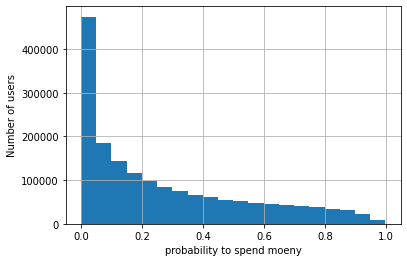

In [64]:
# Histogram of num users versus spending money probabiliy
ax = df_output_03['prob'].hist(bins = 20)
ax.set_xlabel('probability to spend moeny')
ax.set_ylabel('Number of users')
plt.show()

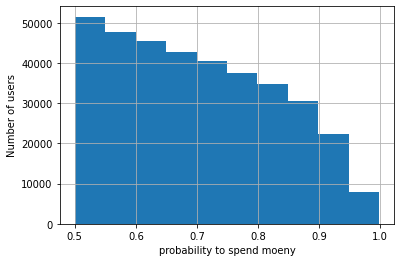

In [66]:
df_tmp = df_output_03.loc[df_output_03.prob >= 0.5]

ax = df_tmp['prob'].hist(bins = 10)
ax.set_xlabel('probability to spend moeny')
ax.set_ylabel('Number of users')
plt.show()

In [74]:
# Based than the above histogram, we can choose the cut-off threshold to determine shortlist of users that having high probablity of spending money to target
# For example if we set cutoff threshold by 0.8, there are roughly 95K users to target that have high probablity to spend money